<a href="https://colab.research.google.com/github/rodolfoarruda/MachineLearning/blob/main/Pratica_ProcImg_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICMC - Instituto de Ciências Matemáticas e de Computação
## SCC5830 - Image Processing (2021)

# Rodolfo Augusto Da Silva Arruda - 6381848

### **Título: Segmentação de lavoura de feijão, com relação à área coberta por vegetação, utilizando imagens coletadas via dispositivo de baixo custo e baixa altitude.**

### **1- Introdução**

#### Segundo (Ponti et al, 2016) a obtenção de imagens via satélites é custosa e pode ser um limitador para estudar aplicações no campo da agricultura de precisão. Como alternativa, o pesquisador afirma que uma solução viável e de baixo custo é a utilização de sensoriamento remoto de baixa altitude, tal como o uso UAVs (veículos aéreos não tripulados) ou dirigíveis para coletar imagens, visando, por exemplo, estimar a produtividade, contar ervas daninhas ou o número de plantas.

#### No referido artigo, os autores utilizaram para os experimentos imagens deste tipo (baixo custo e baixa altitude) para estimar a área plantada de lavouras, as quaisi constituíram dois datasets. O primeiro sobre a cultura de feijões, coletado via um sistema que combina partes de um balão de hélio e uma pipa (Skyhook Helikite) e o segundo coletado via um UAV para coletar dados de cana de açúcar e eucalipto.

#### A identificação dos pixels das imagens com relação às duas classes (área com vegetação ou sem vegetação) foi obtida com auxílio de três especialistas da área de agronomia. A votação entre a opinião dos três constituiu a verdade absoluta com relação ao rótulo.


### **2- Material**

#### Para o propósito deste trabalho será utilizado o conjunto de dados sobre a lavoura de feijão, que é composto por 40 imagens coletadas em dois diferentes campos, sendo 18 de uma cultura mais produtiva (mais área com vegetação) e as 22 restantes de um campo menos produtivas, onde é maior a presença de plantas, ervas daninhas e solo. Todas as imagens foram coletadas a uma altura de 50 metros de altura, com o uso de um sistema dirigível e uma câmera de 10MP, com 24-bit RGB.

#### As imagens obtidas foram cortadas em quadrados de dimensão 512 × 512 pixels e armazenadas em formato PNG. O conjunto de dados final consiste em 29.556 exemplos da classe positiva (72,1% dos pixels) e 11.404 exemplos da classe negativa (27,9% dos pixels).



#### **2.1 - Preparação dos dados**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ler e salvar imagens
from skimage.io import imread_collection
from skimage.io import imsave
from skimage.io import imshow
import random

##### Partição do conjunto de dados 
##### Desenvolvimento: 60% -- 24 imagens 
##### Teste: 20% -- 8 imagens          
##### Validação: 20% -- 8 imagens

In [ ]:
np.random.seed(10)

list  = np.arange(1,41)
dev   = np.random.choice(list, 24, replace=False)
dev_compl = np.setdiff1d(list, dev)
test  = np.random.choice(dev_compl, 8, replace=False)
valid = np.setdiff1d(dev_compl, test)

In [ ]:
print("Train:",dev);print("Test:",test);print("Valid:",valid)

Train: [ 3 28 36 31 15 14  8 25 32 13  6  7  4 22 21 35  2 19 12 38 24 17 20  5]
Test: [18 16 29  9 11 40 34  1]
Valid: [10 23 26 27 30 33 37 39]


##### Imagens

In [ ]:
seq = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/*.png", conserve_memory=True)

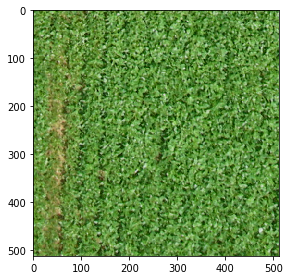

In [ ]:
imshow(seq[1]);

In [ ]:
# Salvar conjunto dev:
for x in dev:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_" + str(x) + ".png",seq[x-1])

In [ ]:
# Salvar conjunto test:
for x in test:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/imagem_" + str(x) + ".png",seq[x-1])

In [ ]:
# Salvar conjunto valid:
for x in valid:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/valid/img/imagem_" + str(x) + ".png",seq[x-1])

##### Rótulos

In [ ]:
rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/*.png", conserve_memory=True)

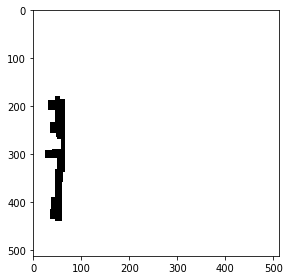

In [ ]:
imshow(rot[1]);

In [ ]:
# Salvar rotulo dev:
for x in dev:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_" + str(x) + ".png",rot[x-1])

In [ ]:
# Salvar rotulo test:
for x in test:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_" + str(x) + ".png",rot[x-1])

In [ ]:
# Salvar rotulo valid:
for x in valid:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/valid/rotulos/imagem_" + str(x) + ".png",rot[x-1])

### **3 - Proposta**

#### Os autores do artigo reportaram que as as principais técnicas utilizadas no estudo foram vegetation indices (ExG, CIVE e NDVI) e visual feature extractors (BIC e Haralick). Afirmaram que essas metodologias são frequentemente usadas em sensoriamento remoto para realizar segmentação ou para fornecer recursos que podem ser usados como entrada para métodos de agrupamento, classificação e regressão. Para a etapa de classificação foi utilizado o modelo SVM, com kernel RBF.

#### Com intuito de testar algumas abordagens diferentes sobre o mesmo problema existe a possibilidade avaliar se faz sentido utilizar outros extratores, sejam os tradicionais (cor, forma, textura) ou extratores do tipo deep features, com diferentes arquiteturas CNN (Inception, Resnet50, VGG16, EfficientNet, etc). A partir das características obtidas, verificar o desempenho de classificadores tradicionais (SVM, OPF, RF, etc) e comparar com o desempenho da classificação fim a fim (end2end) considerando diferentes arquiteturas CNNs, considerando diferentes métricas, como acurácia, especificidade, sensibilidade F1, tempos de extração, treinamento e classificação, dimensionalidade dos vetores de características e etc.

#### **3.1 - Extratores tradicionais**

In [ ]:
#!pip install git+https://github.com/qubvel/segmentation_models
#!pip install mahotas

In [ ]:
%env SM_FRAMEWORK=tf.keras
import mahotas as mt
import keras 
import tensorflow as tf
keras.__version__
import segmentation_models as sm
keras.backend.set_image_data_format('channels_last')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
train = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/*.png", conserve_memory=True)

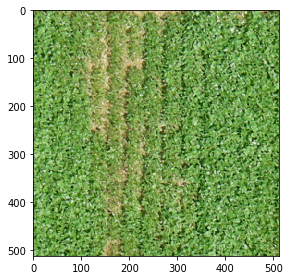

In [ ]:
imshow(train[1]);

##### **3.1.1. Haralick**  

###### Descritores que caracterizam matrizes de co-ocorrência são chamados de descritores de Haralick pelo método ter sido proposto por Robert Haralick (Haralick et al. 1973)

In [ ]:
!pip install git+https://github.com/ProfBressan/FeatureExtraction

  Cloning https://github.com/ProfBressan/FeatureExtraction to /tmp/pip-req-build-4zqm2v71
  Running command git clone -q https://github.com/ProfBressan/FeatureExtraction /tmp/pip-req-build-4zqm2v71
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
class Haralick:
	def __init__(self):
		self.image_path = ''
	def setImagePath(self, image_path):
		self.image_path = image_path
	def getImagePath(self):
		return self.image_path
	def extractionFeatures(self, image_path):
		try:
			self.image_path = image_path
			img = Image.open(self.image_path)
			imgRGB = img.convert('RGB')
			imgGray = imgRGB.convert('L')
			textures = mt.features.haralick(np.asanyarray(imgGray))
			ht_mean = textures.mean(axis=0)
			return ht_mean
		except Exception as e:
			print('\n################# (haralick) - Error Reading Image!  #################\n', e)

In [ ]:
from PIL import Image

img = Image.open('/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_5.png')
imgRGB = img.convert('RGB')
imgGray = imgRGB.convert('L')

array_p = np.asanyarray(imgGray)[0:15,0:15]

textures = mt.features.haralick(array_p)
ht_mean = textures.mean(axis=0)


In [ ]:
ht_mean

array([ 2.74385094e-03,  3.24686480e+02,  7.76460116e-01,  7.27756740e+02,
        6.64178919e-02,  2.16979507e+02,  2.58634048e+03,  6.77940997e+00,
        8.56294707e+00,  1.84640042e-04,  4.96937993e+00, -6.52045307e-01,
        9.99873050e-01])

In [ ]:
imgRGB = img.convert('RGB')
imgGray = imgRGB.convert('L')
a = mt.features.haralick(train[1][0:15,0:15])

In [ ]:
a

array([[ 6.30583900e-02,  1.32427381e+02,  9.87617427e-01,
         5.34732906e+03,  3.24371337e-01,  2.86229762e+02,
         2.12568889e+04,  6.67363068e+00,  8.36304182e+00,
         3.78089957e-04,  4.23392198e+00, -6.34240271e-01,
         9.99788314e-01],
       [ 6.30637300e-02,  2.75062500e+02,  9.73975818e-01,
         5.28474824e+03,  3.05990841e-01,  2.87743622e+02,
         2.08639304e+04,  6.68971482e+00,  8.33379401e+00,
         3.39360299e-04,  4.64432383e+00, -6.36415467e-01,
         9.99790792e-01],
       [ 6.30321712e-02,  1.90764286e+02,  9.81972799e-01,
         5.29101223e+03,  3.19943681e-01,  2.88150000e+02,
         2.09732846e+04,  6.65752509e+00,  8.40502356e+00,
         3.57584359e-04,  4.41630406e+00, -6.26352567e-01,
         9.99765496e-01],
       [ 6.30783723e-02,  2.89584184e+02,  9.72614273e-01,
         5.28713708e+03,  2.91865922e-01,  2.87737245e+02,
         2.08589641e+04,  6.60038105e+00,  8.31208540e+00,
         3.21248033e-04,  4.66193085e

In [ ]:
train[1].shape

(512, 512, 4)

In [ ]:
a

array([[ 6.25607185e-02,  2.13113169e+02,  9.80183002e-01,
         5.37702952e+03,  3.11314564e-01,  2.96799550e+02,
         2.12950049e+04,  7.19476279e+00,  1.09948169e+01,
         3.46551930e-04,  4.55620183e+00, -2.98148185e-01,
         9.89328418e-01],
       [ 6.25460880e-02,  3.86314629e+02,  9.64070943e-01,
         5.37607533e+03,  2.97403366e-01,  2.96821124e+02,
         2.11179867e+04,  7.17978127e+00,  1.12930267e+01,
         3.18138751e-04,  4.88870325e+00, -2.51972483e-01,
         9.80533739e-01],
       [ 6.25597282e-02,  2.22112978e+02,  9.79342882e-01,
         5.37618518e+03,  3.10565226e-01,  2.96842383e+02,
         2.12826277e+04,  7.19397631e+00,  1.10169535e+01,
         3.44877846e-04,  4.57849048e+00, -2.94792642e-01,
         9.88854664e-01],
       [ 6.25451529e-02,  4.06133757e+02,  9.62227654e-01,
         5.37607276e+03,  2.96785662e-01,  2.96821241e+02,
         2.10981573e+04,  7.17797779e+00,  1.13165211e+01,
         3.16473601e-04,  4.91504699e

### Módulos Modeleagem

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


# Referências
### https://github.com/qubvel/segmentation_models
### https://github.com/ProfBressan/FeatureExtraction

### Ponti, M. et al. "Precision Agriculture: using low-cost systems to acquire low-altitude images". IEEE Computer Graphics and Applications, 2016.
